In [11]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import seaborn as sns
import os
import re
from itertools import groupby


#os.chdir('drive/MyDrive/CentralValleyWaterProject/CDEC_data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def load_and_clean_data(station):
    filename = f'{station}.csv'

    # Read only the necessary columns
    df = pd.read_csv(filename, usecols=['DATE TIME', 'VALUE'])

    # Convert 'DATE TIME' to datetime
    df['DATE TIME'] = pd.to_datetime(df['DATE TIME'], format='%Y%m%d %H%M', errors='coerce')

    # Convert 'VALUE' to numeric
    df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')

    # Drop rows with NaN in DATE TIME or VALUE
    df = df.dropna(subset=['DATE TIME', 'VALUE'])

    # Set 'DATE TIME' as index
    df = df.set_index('DATE TIME')

    # Rename 'VALUE' column to include station name
    df = df.rename(columns={'VALUE': f'{station}_value'})

    return df

# Load data for each station
stations = {
    'river_stage': ['YDR', 'TIS', 'SUT', 'SJP', 'SJN', 'SJF', 'SBS', 'RVB', 'NIC', 'LIS', 'KNL', 'GRL', 'FRE', 'FPT', 'DLT', 'BTC'],
    'flow': ['YPB', 'WLK', 'VON', 'VIN'],
    'groundwater': ['YR1'],
    'snow': ['YBP18', 'YBP3'],
    'precipitation': ['WWS']
}

data = {}

for category, station_list in stations.items():
    for station in station_list:
        try:
            df = load_and_clean_data(station)
            data[station] = df
            print(f"Loaded {station}: {len(df)} rows")
        except FileNotFoundError:
            print(f"Warning: File for {station} not found")
        except Exception as e:
            print(f"Error processing {station}: {str(e)}")

# Combine all datasets
combined_df = pd.concat(data.values(), axis=1)

# Resample to daily frequency
combined_df = combined_df.resample('D').mean()

print(f"\nCombined dataframe shape: {combined_df.shape}")
print(combined_df.head())

# Save the processed dataframe
combined_df.to_csv('processed_data.csv')
print("Processed data saved to 'processed_data.csv'")

Loaded YDR: 433776 rows
Loaded TIS: 71312 rows


<ipython-input-5-cb51b6cf0156>:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, usecols=['DATE TIME', 'VALUE'])


Loaded SUT: 530932 rows
Loaded SJP: 161064 rows


<ipython-input-5-cb51b6cf0156>:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, usecols=['DATE TIME', 'VALUE'])


Loaded SJN: 267863 rows
Loaded SJF: 39831 rows
Loaded SBS: 206122 rows
Loaded RVB: 252156 rows
Loaded NIC: 253628 rows
Loaded LIS: 333007 rows
Loaded KNL: 227066 rows
Loaded GRL: 219054 rows
Loaded FRE: 252748 rows
Loaded FPT: 96921 rows
Loaded DLT: 206510 rows
Loaded BTC: 220300 rows
Loaded YPB: 107710 rows
Loaded WLK: 11316 rows
Loaded VON: 11983 rows
Loaded VIN: 11229 rows
Loaded YR1: 22414 rows
Loaded YBP18: 339 rows
Loaded YBP3: 339 rows
Loaded WWS: 108928 rows

Combined dataframe shape: (31891, 24)
            YDR_value  TIS_value  SUT_value  SJP_value  SJN_value  SJF_value  \
DATE TIME                                                                      
1937-03-01        NaN        NaN        NaN        NaN        NaN        NaN   
1937-03-02        NaN        NaN        NaN        NaN        NaN        NaN   
1937-03-03        NaN        NaN        NaN        NaN        NaN        NaN   
1937-03-04        NaN        NaN        NaN        NaN        NaN        NaN   
1937-03-05

In [8]:
# Step 2: Data Preprocessing and Feature Engineering

# Fill missing values
combined_df = combined_df.resample('D').mean()  # Ensure daily frequency
combined_df = combined_df.interpolate(method='time')

# Create aggregate features, only using available stations
available_river_stage = [s for s in stations['river_stage'] if f'{s}_value' in combined_df.columns]
available_flow = [s for s in stations['flow'] if f'{s}_value' in combined_df.columns]

if available_river_stage:
    combined_df['avg_river_stage'] = combined_df[[f'{s}_value' for s in available_river_stage]].mean(axis=1)
    print(f"Averaged river stage from {len(available_river_stage)} stations.")
else:
    print("Warning: No river stage stations available for averaging.")

if available_flow:
    combined_df['avg_flow'] = combined_df[[f'{s}_value' for s in available_flow]].mean(axis=1)
    print(f"Averaged flow from {len(available_flow)} stations.")
else:
    print("Warning: No flow stations available for averaging.")

# Snow water ratio (check if both columns exist)
if 'YBP3_value' in combined_df.columns and 'YBP18_value' in combined_df.columns:
    combined_df['snow_water_ratio'] = combined_df['YBP3_value'] / combined_df['YBP18_value']
    print("Calculated snow water ratio.")
else:
    print("Warning: Unable to calculate snow water ratio. YBP3_value or YBP18_value missing.")

# Create seasonal features
combined_df['dayofyear'] = combined_df.index.dayofyear
combined_df['month'] = combined_df.index.month

# Calculate rolling averages for available columns
for col in ['avg_river_stage', 'avg_flow', 'YR1_value', 'WWS_value']:
    if col in combined_df.columns:
        combined_df[f'{col}_30d_avg'] = combined_df[col].rolling(window=30).mean()
        print(f"Calculated 30-day rolling average for {col}.")
    else:
        print(f"Warning: Unable to calculate rolling average for {col}. Column missing.")

# Step 3: Create Target Variables

# Agricultural Water Availability Index
ag_water_components = []
for col in ['avg_river_stage', 'avg_flow', 'YR1_value', 'YBP3_value']:
    if col in combined_df.columns:
        ag_water_components.append(stats.zscore(combined_df[col].dropna(), nan_policy='omit'))
        print(f"Added {col} to Agricultural Water Availability Index calculation.")
    else:
        print(f"Warning: {col} not available for Agricultural Water Availability Index calculation.")

if ag_water_components:
    combined_df['ag_water_index'] = pd.DataFrame(ag_water_components).mean()
    print("Calculated Agricultural Water Availability Index.")
else:
    print("Error: Unable to calculate Agricultural Water Availability Index. No components available.")

# Define water requirements (example values, should be adjusted based on actual data)
WATER_REQUIREMENT_PER_DAY = 0.1  # hypothetical value

# Sustainable Farming Days
if 'ag_water_index' in combined_df.columns:
    combined_df['sustainable_farming_days'] = combined_df['ag_water_index'].apply(
        lambda x: max(0, x / WATER_REQUIREMENT_PER_DAY)
    )
    print("Calculated Sustainable Farming Days.")
else:
    print("Warning: Unable to calculate Sustainable Farming Days. ag_water_index not available.")

# Print summary of available features
print("\nAvailable features:")
print(combined_df.columns.tolist())

# Print summary statistics
print("\nSummary statistics:")
print(combined_df.describe())

# Print first few rows of the processed dataframe
print("\nFirst few rows of the processed dataframe:")
print(combined_df.head())

Averaged river stage from 16 stations.
Averaged flow from 4 stations.
Calculated snow water ratio.
Calculated 30-day rolling average for avg_river_stage.
Calculated 30-day rolling average for avg_flow.
Calculated 30-day rolling average for YR1_value.
Calculated 30-day rolling average for WWS_value.
Added avg_river_stage to Agricultural Water Availability Index calculation.
Added avg_flow to Agricultural Water Availability Index calculation.
Added YR1_value to Agricultural Water Availability Index calculation.
Added YBP3_value to Agricultural Water Availability Index calculation.
Calculated Agricultural Water Availability Index.
Calculated Sustainable Farming Days.

Available features:
['YDR_value', 'TIS_value', 'SUT_value', 'SJP_value', 'SJN_value', 'SJF_value', 'SBS_value', 'RVB_value', 'NIC_value', 'LIS_value', 'KNL_value', 'GRL_value', 'FRE_value', 'FPT_value', 'DLT_value', 'BTC_value', 'YPB_value', 'WLK_value', 'VON_value', 'VIN_value', 'YR1_value', 'YBP18_value', 'YBP3_value', 'WW

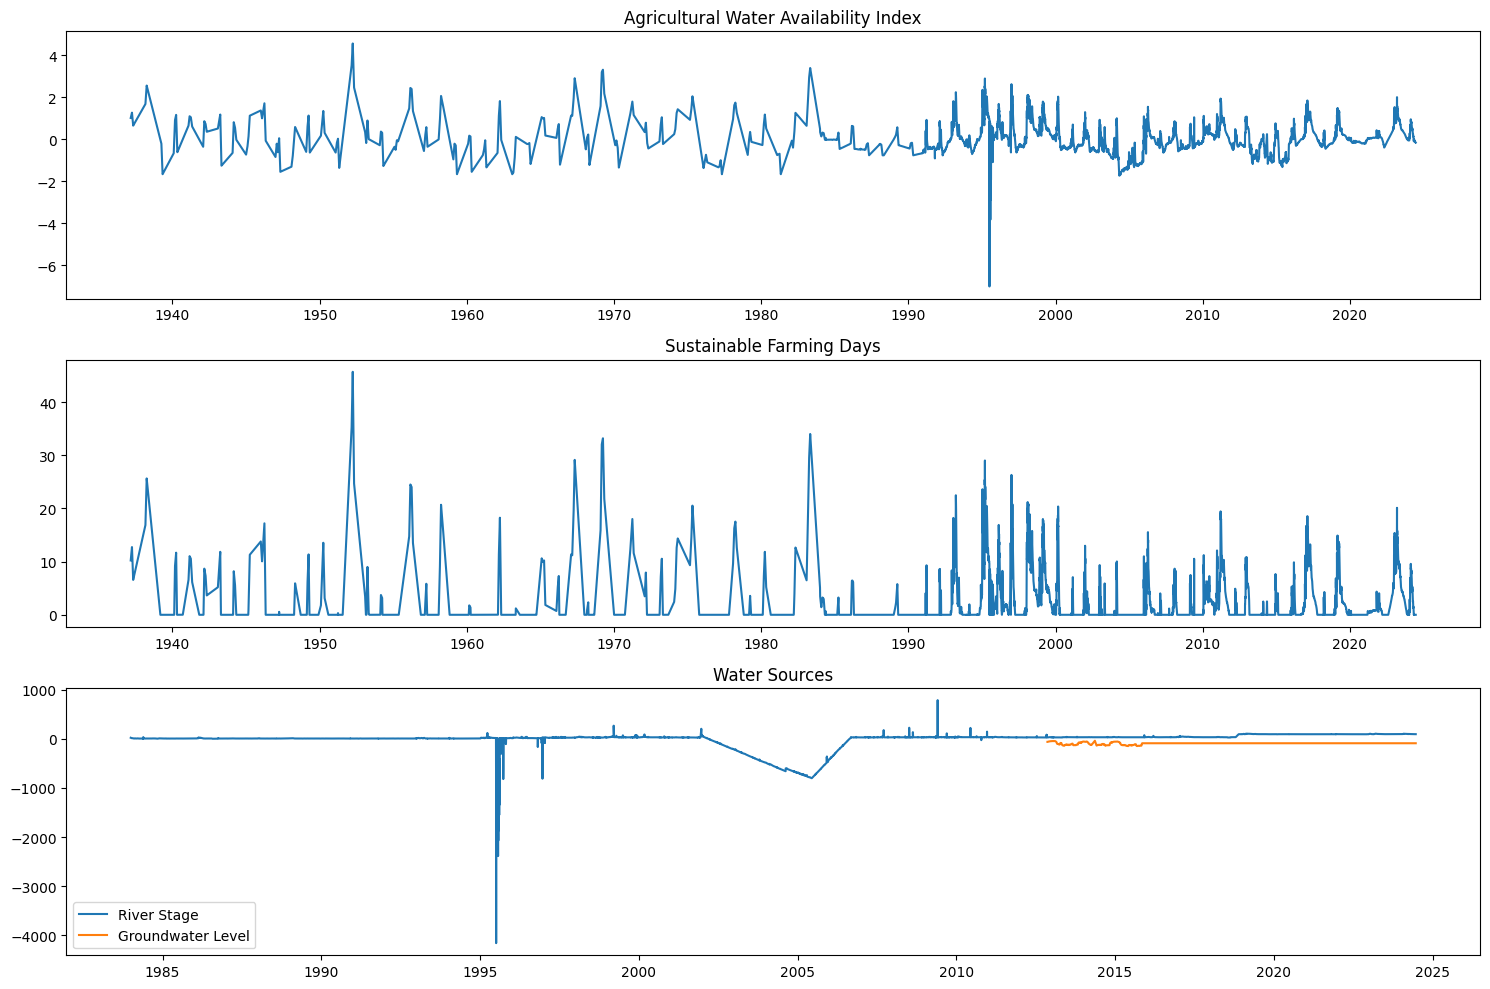


Available columns:
['YDR_value', 'TIS_value', 'SUT_value', 'SJP_value', 'SJN_value', 'SJF_value', 'SBS_value', 'RVB_value', 'NIC_value', 'LIS_value', 'KNL_value', 'GRL_value', 'FRE_value', 'FPT_value', 'DLT_value', 'BTC_value', 'YPB_value', 'WLK_value', 'VON_value', 'VIN_value', 'YR1_value', 'YBP18_value', 'YBP3_value', 'WWS_value', 'dayofyear', 'month', 'avg_river_stage', 'avg_flow', 'snow_water_ratio', 'avg_river_stage_30d_avg', 'avg_flow_30d_avg', 'YR1_value_30d_avg', 'WWS_value_30d_avg', 'ag_water_index', 'sustainable_farming_days', 'ag_water_index_interpolated']
Number of missing values in ag_water_index: 0


<Figure size 1500x1000 with 0 Axes>

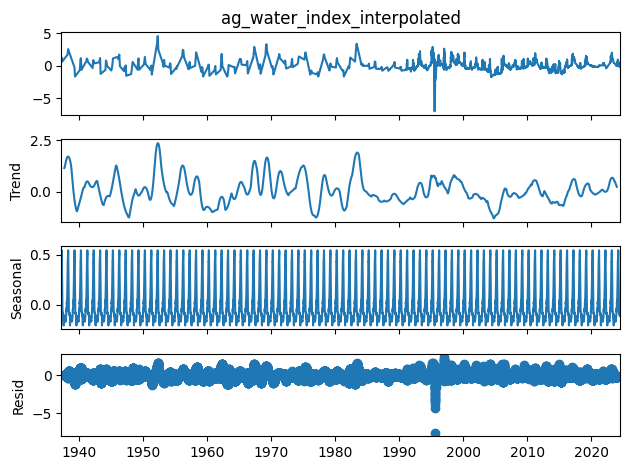

Decomposition performed on data from 1937-03-01 00:00:00 to 2024-06-22 00:00:00
Number of data points used: 31891


<Figure size 1500x1000 with 0 Axes>

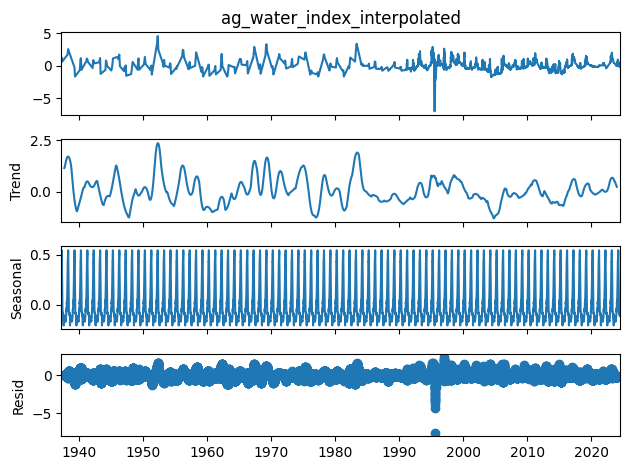

In [12]:
# Step 4: Visualizations
plt.figure(figsize=(15, 10))

if 'ag_water_index' in combined_df.columns:
    plt.subplot(3, 1, 1)
    plt.plot(combined_df.index, combined_df['ag_water_index'])
    plt.title('Agricultural Water Availability Index')
else:
    print("Warning: ag_water_index not available for plotting")

if 'sustainable_farming_days' in combined_df.columns:
    plt.subplot(3, 1, 2)
    plt.plot(combined_df.index, combined_df['sustainable_farming_days'])
    plt.title('Sustainable Farming Days')
else:
    print("Warning: sustainable_farming_days not available for plotting")

plt.subplot(3, 1, 3)
if 'avg_river_stage' in combined_df.columns:
    plt.plot(combined_df.index, combined_df['avg_river_stage'], label='River Stage')
else:
    print("Warning: avg_river_stage not available for plotting")

if 'YR1_value' in combined_df.columns:
    plt.plot(combined_df.index, combined_df['YR1_value'], label='Groundwater Level')
else:
    print("Warning: YR1_value not available for plotting")

plt.legend()
plt.title('Water Sources')
plt.tight_layout()
plt.show()

# Print available columns for debugging
print("\nAvailable columns:")
print(combined_df.columns.tolist())

# Step 5: Time Series Decomposition

# Check for missing values in ag_water_index
print("Number of missing values in ag_water_index:", combined_df['ag_water_index'].isna().sum())

# Interpolate missing values
combined_df['ag_water_index_interpolated'] = combined_df['ag_water_index'].interpolate()

# Find the longest continuous segment without NaNs
mask = combined_df['ag_water_index_interpolated'].notna()
longest_segment = max((list(g) for k, g in groupby(mask.index, key=lambda x: mask[x])), key=len)

# Use this segment for decomposition
decomposition_data = combined_df.loc[longest_segment, 'ag_water_index_interpolated']

# Ensure we have at least two full periods of data
if len(decomposition_data) >= 2*365:
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(decomposition_data, model='additive', period=365)

    # Plot the decomposition
    plt.figure(figsize=(15, 10))
    decomposition.plot()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough consecutive data points for seasonal decomposition")

# Print information about the data used for decomposition
print(f"Decomposition performed on data from {decomposition_data.index[0]} to {decomposition_data.index[-1]}")
print(f"Number of data points used: {len(decomposition_data)}")
plt.figure(figsize=(15, 10))
decomposition.plot()
plt.tight_layout()
plt.show()


In [13]:
# Step 6: Predictive Modeling - LSTM

# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df[['ag_water_index']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/100
717/717 [==============================] - 41s 52ms/step - loss: 0.0051 - val_loss: 2.2070e-04
Epoch 2/100
717/717 [==============================] - 38s 53ms/step - loss: 2.3809e-04 - val_loss: 1.8401e-04
Epoch 3/100
717/717 [==============================] - 37s 52ms/step - loss: 2.0504e-04 - val_loss: 1.5353e-04
Epoch 4/100
717/717 [==============================] - 37s 52ms/step - loss: 1.5836e-04 - val_loss: 9.9710e-05
Epoch 5/100
717/717 [==============================] - 37s 52ms/step - loss: 1.3472e-04 - val_loss: 8.6482e-05
Epoch 6/100
717/717 [==============================] - 37s 52ms/step - loss: 1.1602e-04 - val_loss: 8.7698e-05
Epoch 7/100
717/717 [==============================] - 37s 51ms/step - loss: 1.0598e-04 - val_loss: 6.4396e-05
Epoch 8/100
717/717 [==============================] - 37s 52ms/step - loss: 1.0188e-04 - val_loss: 5.5553e-05
Epoch 9/100
717/717 [==============================] - 37s 51ms/step - loss: 9.6249e-05 - val_loss: 5.4732e-05
Epoch

In [16]:
# Save the entire model to a HDF5 file (.h5 extension)
model.save('LSTM.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Step 7: Predictive Modeling - Prophet

prophet_df = combined_df.reset_index()[['date', 'ag_water_index']]
prophet_df.columns = ['ds', 'y']

m = Prophet()
m.fit(prophet_df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.title('Prophet Forecast of Agricultural Water Availability Index')
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

In [ ]:
# Step 8: Scenario Analysis

# Create function to simulate different scenarios
def simulate_scenario(base_forecast, change_factor, change_start_date):
    scenario_forecast = base_forecast.copy()
    mask = scenario_forecast['ds'] >= change_start_date
    scenario_forecast.loc[mask, 'yhat'] *= change_factor
    return scenario_forecast

# Simulate scenarios
normal_scenario = forecast
dry_scenario = simulate_scenario(forecast, 0.8, pd.Timestamp('2024-01-01'))
wet_scenario = simulate_scenario(forecast, 1.2, pd.Timestamp('2024-01-01'))

# Plot scenarios
plt.figure(figsize=(15, 7))
plt.plot(normal_scenario['ds'], normal_scenario['yhat'], label='Normal Scenario')
plt.plot(dry_scenario['ds'], dry_scenario['yhat'], label='Dry Scenario')
plt.plot(wet_scenario['ds'], wet_scenario['yhat'], label='Wet Scenario')
plt.title('Water Availability Scenarios')
plt.legend()
plt.show()

# Step 9: Correlation Analysis

correlation_columns = ['avg_river_stage', 'avg_flow', 'YR1_value', 'YBP3_value', 'WWS_value', 'ag_water_index']
available_columns = [col for col in correlation_columns if col in combined_df.columns]

correlation_matrix = combined_df[available_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Key Variables')
plt.show()

# Print summary statistics
if 'ag_water_index' in combined_df.columns and 'sustainable_farming_days' in combined_df.columns:
    print(combined_df[['ag_water_index', 'sustainable_farming_days']].describe())
else:
    print("Warning: 'ag_water_index' or 'sustainable_farming_days' not found in the dataframe")

# Print the last 30 days of predictions
print("Last 30 days of predictions:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))

In [ ]:
from mdutils.mdutils import MdUtils
from mdutils import Html
import io
import base64

# Create a new Markdown file
mdFile = MdUtils(file_name='water_availability_report', title='Water Availability Analysis Report')

# Function to save plot to markdown
def add_plot_to_md(fig, mdFile, title):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_str = base64.b64encode(buf.getvalue()).decode('utf-8')
    mdFile.new_header(level=2, title=title)
    mdFile.new_paragraph(Html.image(path='data:image/png;base64,'+img_str, size='800x600'))

# Add introduction
mdFile.new_header(level=1, title="Introduction")
mdFile.new_paragraph("This report presents an analysis of water availability in California's Central Valley, focusing on agricultural water use and sustainability.")

# Add data description
mdFile.new_header(level=1, title="Data Description")
mdFile.new_paragraph("The analysis uses data from various stations measuring river stages, flow rates, groundwater levels, snow depth, and precipitation. Data was preprocessed to handle missing values and aggregated to daily frequency.")

# Add visualizations
mdFile.new_header(level=1, title="Visualizations")

# Assuming you've already created these plots, just save them to the report
add_plot_to_md(plt.gcf(), mdFile, 'Water Availability Visualization')

# Time Series Decomposition
if 'decomposition' in locals():
    fig = plt.figure(figsize=(15, 10))
    decomposition.plot()
    add_plot_to_md(fig, mdFile, 'Time Series Decomposition')

# If you've done LSTM modeling
if 'history' in locals():
    plt.figure(figsize=(15, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.legend()
    add_plot_to_md(plt.gcf(), mdFile, 'LSTM Model Training History')

# If you've done Prophet forecasting
if 'm' in locals():
    fig1 = m.plot(forecast)
    add_plot_to_md(fig1, mdFile, 'Prophet Forecast of Agricultural Water Availability Index')

    fig2 = m.plot_components(forecast)
    add_plot_to_md(fig2, mdFile, 'Prophet Forecast Components')

# Scenario Analysis
if 'normal_scenario' in locals():
    plt.figure(figsize=(15, 7))
    plt.plot(normal_scenario['ds'], normal_scenario['yhat'], label='Normal Scenario')
    plt.plot(dry_scenario['ds'], dry_scenario['yhat'], label='Dry Scenario')
    plt.plot(wet_scenario['ds'], wet_scenario['yhat'], label='Wet Scenario')
    plt.title('Water Availability Scenarios')
    plt.legend()
    add_plot_to_md(plt.gcf(), mdFile, 'Water Availability Scenarios')

# Correlation Analysis
if 'correlation_matrix' in locals():
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Key Variables')
    add_plot_to_md(plt.gcf(), mdFile, 'Correlation Matrix of Key Variables')

# Add summary statistics to the report
mdFile.new_header(level=1, title='Summary Statistics')
if 'ag_water_index' in combined_df.columns and 'sustainable_farming_days' in comb